## UNZIPPING DATA

In [1]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!unzip lfw_funneled.zip

Archive:  lfw_funneled.zip
replace lfw_funneled/George_HW_Bush/George_HW_Bush_0001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras as ks
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import random as rand
import seaborn as sns
import scipy as sci
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
import os
import cv2
from math import log10, sqrt
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet50 import decode_predictions
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.utils import to_categorical
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
import mtcnn
from PIL import Image
from scipy import ndimage
from tqdm import tqdm

**LOADING MTCNN MODEL**

In [4]:
detector = mtcnn.MTCNN()

LOADING DATA AND EXTRACTING FACE FROM THE PICTURE

In [5]:
Training = []
Result_Training = []
for dirname, _, filenames in os.walk('/content/lfw_funneled/'):
    for filename in filenames:
        img = cv2.imread(os.path.join(dirname, filename))
        Result_Training.append(filename.split("_")[0])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        result = detector.detect_faces(img)
        x1, y1, h, w = result[0]["box"]
        x2, y2 = x1 + w, y1 + h
        face = img[y1:y2, x1:x2]
        print("Face Dimentions: ", face.shape)
        img = cv2.resize(face, (128, 128))
        Training.append(img)
np.array(Training).shape, np.array(Result_Training).shape

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 19ms/step
Face Dimentions:  (94, 129, 3)
1/1 [==============================] - 0s 19ms/step
Face Dimentions:  (97, 125, 3)
1/1 [==============================] - 0s 21ms/step
Face Dimentions:  (98, 132, 3)
1/1 [==============================] - 0s 20ms/step
Face Dimentions:  (99, 129, 3)
1/1 [==============================] - 0s 20ms/step
Face Dimentions:  (94, 127, 3)
1/1 [==============================] - 0s 19ms/step
Face Dimentions:  (98, 122, 3)
1/1 [==============================] - 0s 19ms/step
Face Dimentions:  (96, 132, 3)
1/1 [==============================] - 0s 20ms/step
Face Dimentions:  (99, 135, 3)
1/1 [==============================] - 0s 25ms/step
Face Dimentions:  (99, 138, 3)
1/1 [==============================] - 0s 28ms/step
Face Dimentions:  (95, 134, 3)
1/1 [==============================] - 0s 43ms/step
Face Dimentions:  (95, 126, 3)
1/1 [==============================]

((621, 128, 128, 3), (621,))

# DATA PREPROCESSING

In [6]:
Result = Result_Training
np.array(Result).shape

(621,)

In [7]:
lb = LabelEncoder()
Result = lb.fit_transform(Result)

In [8]:
Temp = []
for i in Result:
    temp = []
    temp.append(i)
    Temp.append(temp)
output_matrix = to_categorical(Temp)
total = output_matrix.shape[1]
output_matrix.shape

(621, 48)

FUCTIONS FOR PSNR AND SSIM

In [9]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return round(psnr, 2)

In [10]:
def SSIMS(original, compressed):
  return round(ssim(original, compressed, multichannel=True), 2)

In [11]:
def Print_ALL(original, compressed):
  print("PSRN: ", PSNR(original, compressed))
  print("SSIM: ", SSIMS(original, compressed))

DOWNSAMPLING CODE FOR IMAGES TO CONVERT THEM TO LR

In [12]:
def down_sampling(ar, fact):
    res = ar[::fact, ::fact, :]
    return res

In [13]:
LR = []
for i in tqdm(range(len(Training)),desc="CONVERTING"):
  LR.append(down_sampling(Training[i], 4))
np.array(LR).shape

CONVERTING: 100%|██████████| 621/621 [00:00<00:00, 303220.35it/s]


(621, 32, 32, 3)

TRUTH GROUND IMAGES AND LR IMAGES

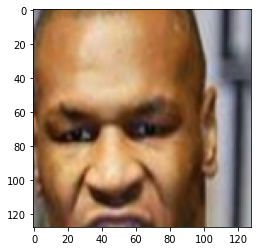

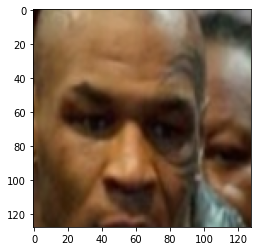

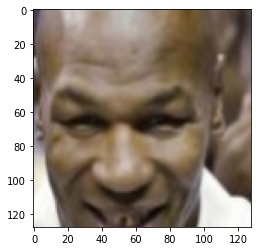

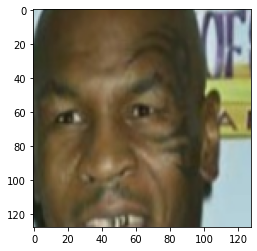

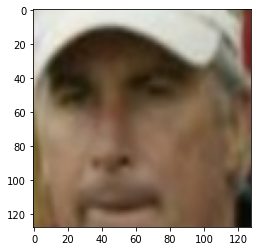

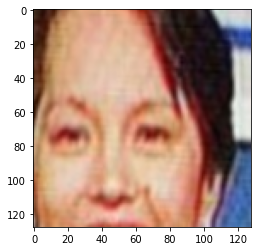

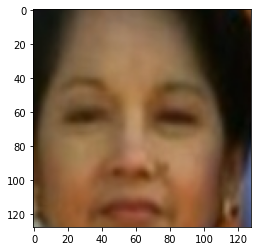

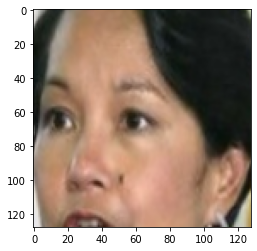

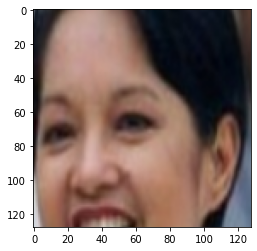

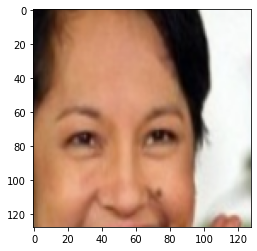

In [14]:
for i in range(10):
    plt.imshow(Training[i])
    plt.show()

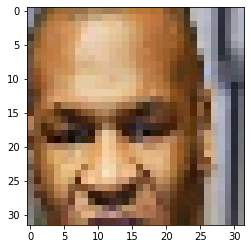

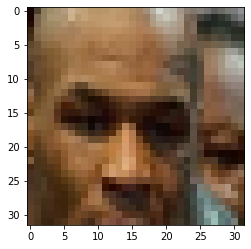

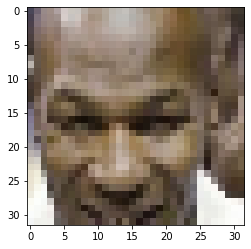

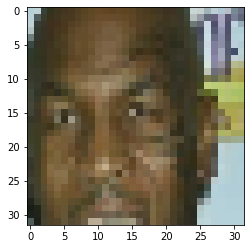

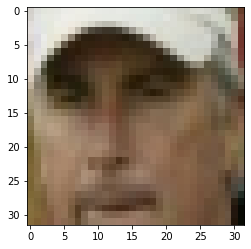

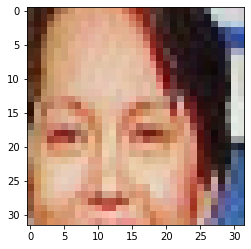

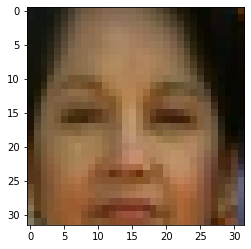

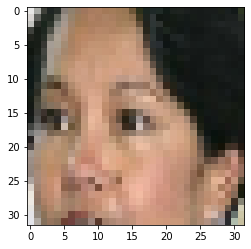

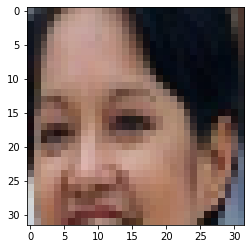

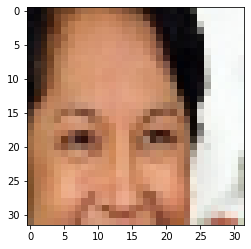

In [15]:
for i in range(10):
    plt.imshow(LR[i])
    plt.show()

# LAPSRN

In [16]:
super_res = cv2.dnn_superres.DnnSuperResImpl_create()
super_res.readModel('/content/LapSRN_x4.pb')
super_res.setModel('lapsrn',4)

In [17]:
Temp_Train = []
for i in tqdm(range(len(LR)),desc="UPSAMPLING"):
  img = super_res.upsample(LR[i])
  Temp_Train.append(img)

UPSAMPLING: 100%|██████████| 621/621 [01:07<00:00,  9.15it/s]


**RESULT OF UPSAMPLING**

In [18]:
Print_ALL(np.array(Training), np.array(Temp_Train))

PSRN:  31.14
SSIM:  0.94


**TAINING AND TESTING DATA**

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(np.array(Temp_Train), np.array(output_matrix), shuffle=True, random_state=128, train_size=.80)
X_train.shape, X_test.shape 

((496, 128, 128, 3), (125, 128, 128, 3))

# RESNET50 MODEL

In [20]:
resnet_model = Sequential()
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(128, 128, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(2048, activation='relu'))
resnet_model.add(Dense(total, activation='softmax'))

94765736/94765736 [==============================] - 3s 0us/step


In [21]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 2048)              4196352   
                                                                 
 dense_8 (Dense)             (None, 48)                98352     
                                                                 
Total params: 27,882,416
Trainable params: 4,294,704
Non-trainable params: 23,587,712
_________________________________________________________________


In [22]:
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = resnet_model.fit(X_train, Y_train, batch_size=32, epochs=10, validation_split=0.25)

Epoch 1/10
12/12 [==============================] - 8s 234ms/step - loss: 7.4485 - accuracy: 0.2285 - precision: 0.3130 - recall: 0.1935 - val_loss: 3.6028 - val_accuracy: 0.3306 - val_precision: 0.6552 - val_recall: 0.3065
Epoch 2/10
12/12 [==============================] - 1s 50ms/step - loss: 2.1993 - accuracy: 0.5134 - precision: 0.7094 - recall: 0.3871 - val_loss: 1.9633 - val_accuracy: 0.5484 - val_precision: 0.9268 - val_recall: 0.3065
Epoch 3/10
12/12 [==============================] - 1s 52ms/step - loss: 1.1036 - accuracy: 0.7285 - precision: 0.9095 - recall: 0.5403 - val_loss: 1.5550 - val_accuracy: 0.6210 - val_precision: 0.9242 - val_recall: 0.4919
Epoch 4/10
12/12 [==============================] - 1s 49ms/step - loss: 0.6293 - accuracy: 0.8683 - precision: 0.9576 - recall: 0.7285 - val_loss: 1.6783 - val_accuracy: 0.5887 - val_precision: 0.8548 - val_recall: 0.4274
Epoch 5/10
12/12 [==============================] - 1s 51ms/step - loss: 0.3561 - accuracy: 0.9194 - precis

# IMPORTANT PLOTS

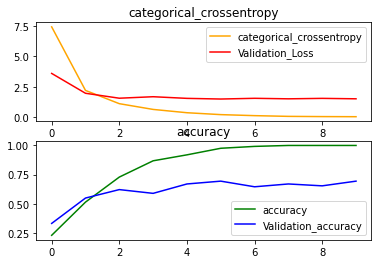

In [23]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.plot(history.history["val_loss"], color='red')
plt.legend(["categorical_crossentropy", "Validation_Loss"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.plot(history.history["val_accuracy"], color='blue')
plt.legend(["accuracy", "Validation_accuracy"])
plt.title("accuracy")
plt.show()

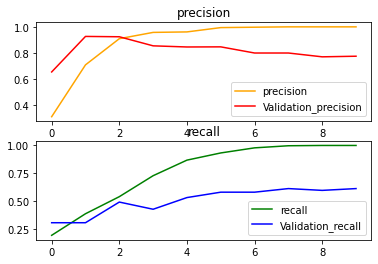

In [24]:
plt.subplot(2,1,1)
plt.plot(history.history["precision"], color='orange')
plt.plot(history.history["val_precision"], color='red')
plt.legend(["precision", "Validation_precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall"], color='green')
plt.plot(history.history["val_recall"], color='blue')
plt.legend(["recall", "Validation_recall"])
plt.title("recall")
plt.show()

# ANSWERS

In [25]:
answer = resnet_model.evaluate(X_test, Y_test)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

4/4 [==============================] - 1s 196ms/step - loss: 1.6138 - accuracy: 0.6960 - precision: 0.7619 - recall: 0.6400
ACCURACY:  0.7
LOSS:  1.61
Precision:  0.76
Recall:  0.64


In [26]:
pre = resnet_model.predict(X_test)

4/4 [==============================] - 1s 31ms/step


In [27]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(Y_test[i]))

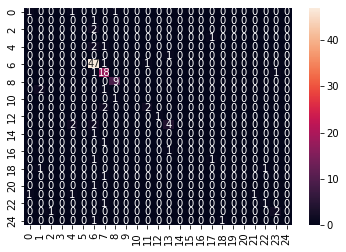

In [28]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

# MOBILENETv2

In [29]:
mobile_model = Sequential()
pretrained_model= MobileNetV2(include_top=False,
                   input_shape=(128, 128, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

mobile_model.add(pretrained_model)
mobile_model.add(Flatten())
mobile_model.add(Dense(2048, activation='relu'))
mobile_model.add(Dense(total, activation='softmax'))

9406464/9406464 [==============================] - 1s 0us/step


In [30]:
mobile_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = mobile_model.fit(X_train, Y_train, batch_size=32, epochs=10, validation_split=0.25)

Epoch 1/10
12/12 [==============================] - 6s 221ms/step - loss: 4.2420 - accuracy: 0.2366 - precision_1: 0.3243 - recall_1: 0.1613 - val_loss: 3.0323 - val_accuracy: 0.3548 - val_precision_1: 0.4737 - val_recall_1: 0.2177
Epoch 2/10
12/12 [==============================] - 0s 29ms/step - loss: 2.6222 - accuracy: 0.3710 - precision_1: 0.5082 - recall_1: 0.1667 - val_loss: 2.5198 - val_accuracy: 0.3468 - val_precision_1: 0.5000 - val_recall_1: 0.0726
Epoch 3/10
12/12 [==============================] - 0s 25ms/step - loss: 2.1750 - accuracy: 0.4489 - precision_1: 0.7848 - recall_1: 0.1667 - val_loss: 2.3544 - val_accuracy: 0.3952 - val_precision_1: 0.6364 - val_recall_1: 0.2258
Epoch 4/10
12/12 [==============================] - 0s 24ms/step - loss: 1.9176 - accuracy: 0.4839 - precision_1: 0.7953 - recall_1: 0.2715 - val_loss: 2.4518 - val_accuracy: 0.3710 - val_precision_1: 0.4800 - val_recall_1: 0.0968
Epoch 5/10
12/12 [==============================] - 0s 26ms/step - loss: 1.

**Graphs**

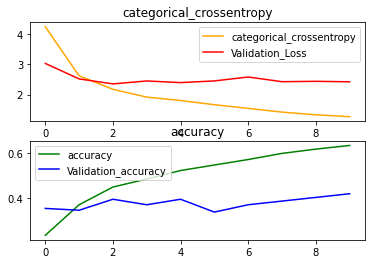

In [31]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.plot(history.history["val_loss"], color='red')
plt.legend(["categorical_crossentropy", "Validation_Loss"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.plot(history.history["val_accuracy"], color='blue')
plt.legend(["accuracy", "Validation_accuracy"])
plt.title("accuracy")
plt.show()

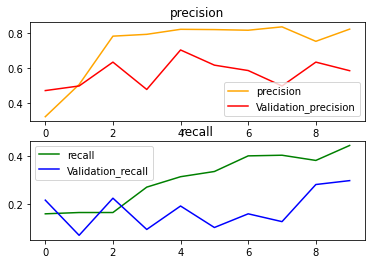

In [32]:
plt.subplot(2,1,1)
plt.plot(history.history["precision_1"], color='orange')
plt.plot(history.history["val_precision_1"], color='red')
plt.legend(["precision", "Validation_precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall_1"], color='green')
plt.plot(history.history["val_recall_1"], color='blue')
plt.legend(["recall", "Validation_recall"])
plt.title("recall")
plt.show()

**Answers**

In [33]:
answer = mobile_model.evaluate(X_test, Y_test)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

4/4 [==============================] - 0s 100ms/step - loss: 2.3989 - accuracy: 0.4560 - precision_1: 0.5902 - recall_1: 0.2880
ACCURACY:  0.46
LOSS:  2.4
Precision:  0.59
Recall:  0.29


In [34]:
pre = mobile_model.predict(X_test)

4/4 [==============================] - 1s 12ms/step


In [35]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(Y_test[i]))

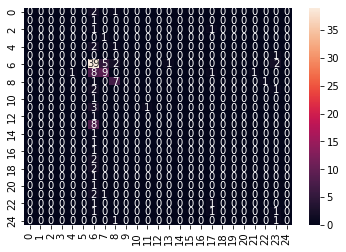

In [36]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

# EDSR MODEL

In [37]:
super_res = cv2.dnn_superres.DnnSuperResImpl_create()
super_res.readModel('/content/EDSR_x4.pb')
super_res.setModel('edsr',4)

In [38]:
Temp_Train = []
for i in tqdm(range(len(LR)),desc="UPSAMPLING"):
  img = super_res.upsample(LR[i])
  Temp_Train.append(img)

UPSAMPLING: 100%|██████████| 621/621 [23:21<00:00,  2.26s/it]


**Comapring The SR result**

In [39]:
Print_ALL(np.array(Training), np.array(Temp_Train))

PSRN:  31.17
SSIM:  0.94


**TESTING AND TRAINING**

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(np.array(Temp_Train), np.array(output_matrix), shuffle=True, random_state=128, train_size=.80)
X_train.shape, X_test.shape 

((496, 128, 128, 3), (125, 128, 128, 3))

# RESNET50 MODEL

In [41]:
resnet_model = Sequential()
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(128, 128, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(2048, activation='relu'))
resnet_model.add(Dense(total, activation='softmax'))

In [42]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_11 (Dense)            (None, 2048)              4196352   
                                                                 
 dense_12 (Dense)            (None, 48)                98352     
                                                                 
Total params: 27,882,416
Trainable params: 4,294,704
Non-trainable params: 23,587,712
_________________________________________________________________


In [43]:
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = resnet_model.fit(X_train, Y_train, batch_size=32, epochs=10, validation_split=0.25)

Epoch 1/10
12/12 [==============================] - 6s 155ms/step - loss: 6.8465 - accuracy: 0.2312 - precision_2: 0.2987 - recall_2: 0.1855 - val_loss: 3.9019 - val_accuracy: 0.4113 - val_precision_2: 0.4845 - val_recall_2: 0.3790
Epoch 2/10
12/12 [==============================] - 1s 50ms/step - loss: 2.1266 - accuracy: 0.5591 - precision_2: 0.8305 - recall_2: 0.3952 - val_loss: 2.1974 - val_accuracy: 0.5403 - val_precision_2: 0.7600 - val_recall_2: 0.4597
Epoch 3/10
12/12 [==============================] - 1s 51ms/step - loss: 1.0534 - accuracy: 0.7124 - precision_2: 0.8996 - recall_2: 0.6263 - val_loss: 1.5739 - val_accuracy: 0.6613 - val_precision_2: 0.9206 - val_recall_2: 0.4677
Epoch 4/10
12/12 [==============================] - 1s 51ms/step - loss: 0.5751 - accuracy: 0.8763 - precision_2: 0.9751 - recall_2: 0.7366 - val_loss: 1.5873 - val_accuracy: 0.6210 - val_precision_2: 0.8171 - val_recall_2: 0.5403
Epoch 5/10
12/12 [==============================] - 1s 51ms/step - loss: 0.

**graphs**

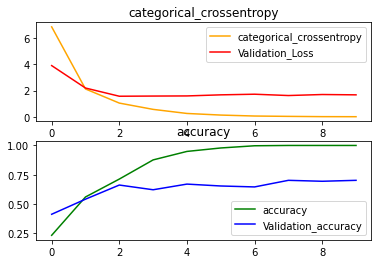

In [44]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.plot(history.history["val_loss"], color='red')
plt.legend(["categorical_crossentropy", "Validation_Loss"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.plot(history.history["val_accuracy"], color='blue')
plt.legend(["accuracy", "Validation_accuracy"])
plt.title("accuracy")
plt.show()

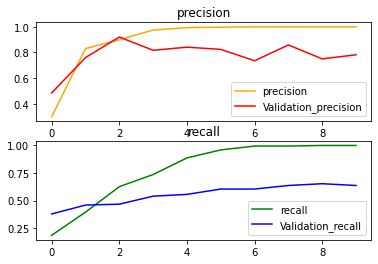

In [45]:
plt.subplot(2,1,1)
plt.plot(history.history["precision_2"], color='orange')
plt.plot(history.history["val_precision_2"], color='red')
plt.legend(["precision", "Validation_precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall_2"], color='green')
plt.plot(history.history["val_recall_2"], color='blue')
plt.legend(["recall", "Validation_recall"])
plt.title("recall")
plt.show()

**Answer**

In [46]:
answer = resnet_model.evaluate(X_test, Y_test)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

4/4 [==============================] - 0s 47ms/step - loss: 1.7464 - accuracy: 0.6640 - precision_2: 0.7500 - recall_2: 0.6000
ACCURACY:  0.66
LOSS:  1.75
Precision:  0.75
Recall:  0.6


In [47]:
pre = resnet_model.predict(X_test)

4/4 [==============================] - 1s 33ms/step


In [48]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(Y_test[i]))

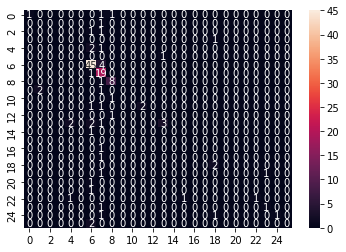

In [49]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

# MOBILENETv2

In [50]:
mobile_model = Sequential()
pretrained_model= MobileNetV2(include_top=False,
                   input_shape=(128, 128, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

mobile_model.add(pretrained_model)
mobile_model.add(Flatten())
mobile_model.add(Dense(2048, activation='relu'))
mobile_model.add(Dense(total, activation='softmax'))

In [51]:
mobile_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = mobile_model.fit(X_train, Y_train, batch_size=32, epochs=10, validation_split=0.25)

Epoch 1/10
12/12 [==============================] - 5s 156ms/step - loss: 3.8362 - accuracy: 0.2473 - precision_3: 0.3693 - recall_3: 0.1747 - val_loss: 3.0557 - val_accuracy: 0.3306 - val_precision_3: 0.3580 - val_recall_3: 0.2339
Epoch 2/10
12/12 [==============================] - 0s 38ms/step - loss: 2.3589 - accuracy: 0.4409 - precision_3: 0.6071 - recall_3: 0.1828 - val_loss: 2.4813 - val_accuracy: 0.4113 - val_precision_3: 0.4400 - val_recall_3: 0.3548
Epoch 3/10
12/12 [==============================] - 0s 36ms/step - loss: 2.1463 - accuracy: 0.4543 - precision_3: 0.5868 - recall_3: 0.2634 - val_loss: 2.5040 - val_accuracy: 0.4435 - val_precision_3: 0.8571 - val_recall_3: 0.0968
Epoch 4/10
12/12 [==============================] - 0s 25ms/step - loss: 1.8684 - accuracy: 0.5134 - precision_3: 0.7568 - recall_3: 0.3011 - val_loss: 2.3921 - val_accuracy: 0.4032 - val_precision_3: 0.6034 - val_recall_3: 0.2823
Epoch 5/10
12/12 [==============================] - 0s 26ms/step - loss: 1.

**Graphs**

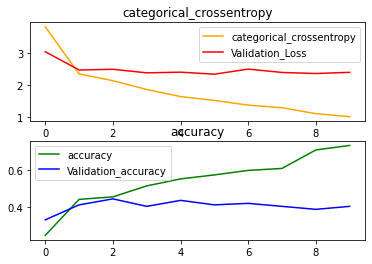

In [52]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.plot(history.history["val_loss"], color='red')
plt.legend(["categorical_crossentropy", "Validation_Loss"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.plot(history.history["val_accuracy"], color='blue')
plt.legend(["accuracy", "Validation_accuracy"])
plt.title("accuracy")
plt.show()

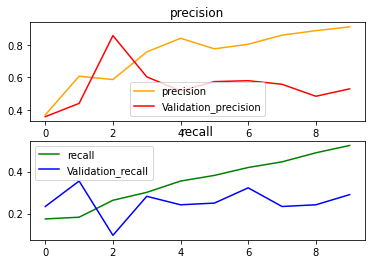

In [53]:
plt.subplot(2,1,1)
plt.plot(history.history["precision_3"], color='orange')
plt.plot(history.history["val_precision_3"], color='red')
plt.legend(["precision", "Validation_precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall_3"], color='green')
plt.plot(history.history["val_recall_3"], color='blue')
plt.legend(["recall", "Validation_recall"])
plt.title("recall")
plt.show()

**ANSWERS**

In [54]:
answer = mobile_model.evaluate(X_test, Y_test)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

4/4 [==============================] - 0s 19ms/step - loss: 2.2549 - accuracy: 0.4720 - precision_3: 0.6119 - recall_3: 0.3280
ACCURACY:  0.47
LOSS:  2.25
Precision:  0.61
Recall:  0.33


In [55]:
pre = mobile_model.predict(X_test)

4/4 [==============================] - 1s 12ms/step


In [56]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(Y_test[i]))

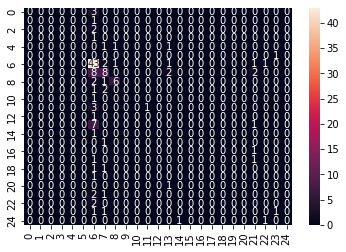

In [57]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

# BICUBIC MODEL

In [58]:
Temp_Train = []
for i in tqdm(range(len(LR)),desc="UPSAMPLING"):
  img = cv2.resize(LR[i], (128, 128), interpolation=cv2.INTER_CUBIC)
  Temp_Train.append(img)

UPSAMPLING: 100%|██████████| 621/621 [00:00<00:00, 17452.85it/s]


**RESULTS**

In [59]:
Print_ALL(np.array(Training), np.array(Temp_Train))

PSRN:  31.01
SSIM:  0.94


In [60]:
X_train, X_test, Y_train, Y_test = train_test_split(np.array(Temp_Train), np.array(output_matrix), shuffle=True, random_state=128, train_size=.80)
X_train.shape, X_test.shape 

((496, 128, 128, 3), (125, 128, 128, 3))

# RESNET50 MODEL

In [61]:
resnet_model = Sequential()
pretrained_mRESULTSodel= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(128, 128, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(2048, activation='relu'))
resnet_model.add(Dense(total, activation='softmax'))

In [62]:
resnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 flatten_6 (Flatten)         (None, 1280)              0         
                                                                 
 dense_15 (Dense)            (None, 2048)              2623488   
                                                                 
 dense_16 (Dense)            (None, 48)                98352     
                                                                 
Total params: 4,979,824
Trainable params: 2,721,840
Non-trainable params: 2,257,984
_________________________________________________________________


In [63]:
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = resnet_model.fit(X_train, Y_train, batch_size=32, epochs=10, validation_split=0.25)

Epoch 1/10
12/12 [==============================] - 4s 123ms/step - loss: 4.1868 - accuracy: 0.2392 - precision_4: 0.2637 - recall_4: 0.1425 - val_loss: 3.3026 - val_accuracy: 0.3226 - val_precision_4: 1.0000 - val_recall_4: 0.0161
Epoch 2/10
12/12 [==============================] - 0s 34ms/step - loss: 2.5709 - accuracy: 0.4328 - precision_4: 0.6562 - recall_4: 0.1694 - val_loss: 2.6106 - val_accuracy: 0.3871 - val_precision_4: 0.5116 - val_recall_4: 0.1774
Epoch 3/10
12/12 [==============================] - 0s 25ms/step - loss: 2.0768 - accuracy: 0.4785 - precision_4: 0.7143 - recall_4: 0.2688 - val_loss: 2.4811 - val_accuracy: 0.4032 - val_precision_4: 0.4844 - val_recall_4: 0.2500
Epoch 4/10
12/12 [==============================] - 0s 25ms/step - loss: 1.8488 - accuracy: 0.5242 - precision_4: 0.7267 - recall_4: 0.3360 - val_loss: 2.4778 - val_accuracy: 0.4113 - val_precision_4: 0.5357 - val_recall_4: 0.1210
Epoch 5/10
12/12 [==============================] - 0s 24ms/step - loss: 1.

**Graphs**

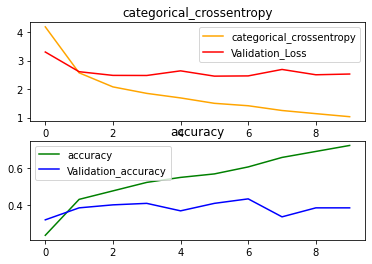

In [64]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.plot(history.history["val_loss"], color='red')
plt.legend(["categorical_crossentropy", "Validation_Loss"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.plot(history.history["val_accuracy"], color='blue')
plt.legend(["accuracy", "Validation_accuracy"])
plt.title("accuracy")
plt.show()

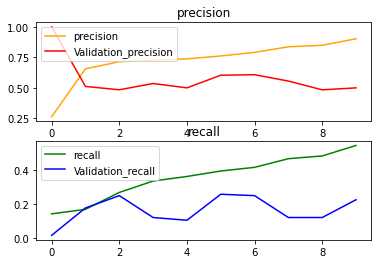

In [65]:
plt.subplot(2,1,1)
plt.plot(history.history["precision_4"], color='orange')
plt.plot(history.history["val_precision_4"], color='red')
plt.legend(["precision", "Validation_precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall_4"], color='green')
plt.plot(history.history["val_recall_4"], color='blue')
plt.legend(["recall", "Validation_recall"])
plt.title("recall")
plt.show()

**Answers**

In [66]:
answer = resnet_model.evaluate(X_test, Y_test)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

4/4 [==============================] - 0s 22ms/step - loss: 2.4758 - accuracy: 0.4560 - precision_4: 0.5455 - recall_4: 0.2400
ACCURACY:  0.46
LOSS:  2.48
Precision:  0.55
Recall:  0.24


In [67]:
pre = resnet_model.predict(X_test)

4/4 [==============================] - 1s 18ms/step


In [68]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(Y_test[i]))

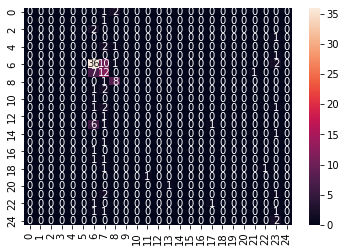

In [69]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

# MOBILENETv2

In [70]:
mobile_model = Sequential()
pretrained_model= MobileNetV2(include_top=False,
                   input_shape=(128, 128, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

mobile_model.add(pretrained_model)
mobile_model.add(Flatten())
mobile_model.add(Dense(2048, activation='relu'))
mobile_model.add(Dense(total, activation='softmax'))

In [71]:
mobile_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = mobile_model.fit(X_train, Y_train, batch_size=32, epochs=10, validation_split=0.25)

Epoch 1/10
12/12 [==============================] - 5s 119ms/step - loss: 4.3191 - accuracy: 0.2500 - precision_5: 0.3246 - recall_5: 0.1667 - val_loss: 3.0196 - val_accuracy: 0.3710 - val_precision_5: 0.3922 - val_recall_5: 0.3226
Epoch 2/10
12/12 [==============================] - 0s 26ms/step - loss: 2.5901 - accuracy: 0.3333 - precision_5: 0.4573 - recall_5: 0.2016 - val_loss: 2.5443 - val_accuracy: 0.4113 - val_precision_5: 0.5294 - val_recall_5: 0.2177
Epoch 3/10
12/12 [==============================] - 0s 25ms/step - loss: 2.0786 - accuracy: 0.4839 - precision_5: 0.7850 - recall_5: 0.2258 - val_loss: 2.4004 - val_accuracy: 0.4113 - val_precision_5: 0.5333 - val_recall_5: 0.0645
Epoch 4/10
12/12 [==============================] - 0s 25ms/step - loss: 1.8667 - accuracy: 0.5188 - precision_5: 0.8043 - recall_5: 0.2984 - val_loss: 2.3555 - val_accuracy: 0.3952 - val_precision_5: 0.5714 - val_recall_5: 0.1290
Epoch 5/10
12/12 [==============================] - 0s 25ms/step - loss: 1.

**graphs**

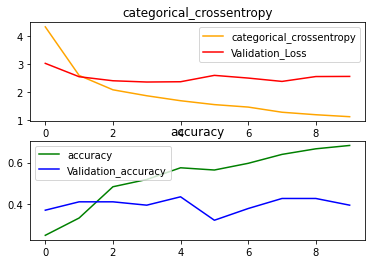

In [72]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.plot(history.history["val_loss"], color='red')
plt.legend(["categorical_crossentropy", "Validation_Loss"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.plot(history.history["val_accuracy"], color='blue')
plt.legend(["accuracy", "Validation_accuracy"])
plt.title("accuracy")
plt.show()

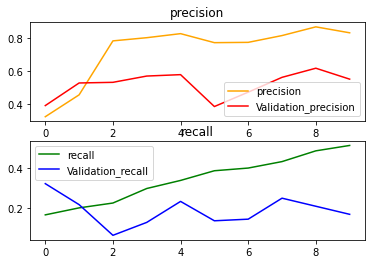

In [73]:
plt.subplot(2,1,1)
plt.plot(history.history["precision_5"], color='orange')
plt.plot(history.history["val_precision_5"], color='red')
plt.legend(["precision", "Validation_precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall_5"], color='green')
plt.plot(history.history["val_recall_5"], color='blue')
plt.legend(["recall", "Validation_recall"])
plt.title("recall")
plt.show()

**Answers**

In [74]:
answer = mobile_model.evaluate(X_test, Y_test)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

4/4 [==============================] - 0s 17ms/step - loss: 2.3932 - accuracy: 0.4240 - precision_5: 0.5814 - recall_5: 0.2000
ACCURACY:  0.42
LOSS:  2.39
Precision:  0.58
Recall:  0.2


In [75]:
pre = mobile_model.predict(X_test)

4/4 [==============================] - 1s 12ms/step


In [76]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(Y_test[i]))

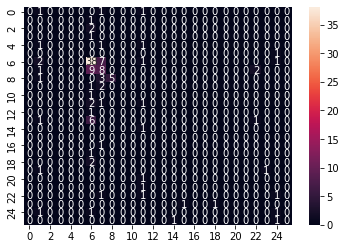

In [77]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)